<a href="https://colab.research.google.com/github/csabi0312/Road-Traffic-sign-detection-and-classifiction-using-Python-Keras-and-CNN/blob/main/traffic_sign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 11.3 MB/s eta 0:00:00


In [3]:
pip install xmltodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [5]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
import keras_tuner
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import load_model
import xml.etree.ElementTree as ET
import cv2
from google.colab.patches import cv2_imshow

<ipython-input-5-ee2a7f0a0ce1>:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Dataset

## Labels

In [6]:
def xml_to_dict(xml_string):
    root = ET.fromstring(xml_string)
    result = {}
    for child in root:
        if len(child) == 0:
            result[child.tag] = child.text
        else:
            result[child.tag] = xml_to_dict(ET.tostring(child))
    return result

In [7]:
def load_labels(file_path):
    fileptr = open(file_path.numpy(),"r").read()
    dicti=xml_to_dict(fileptr)

    width=int(dicti["size"]["width"])
    height=int(dicti["size"]["height"])
    label=dicti["object"]["name"]
    xmin=int(dicti["object"]["bndbox"]["xmin"])
    ymin=int(dicti["object"]["bndbox"]["ymin"])
    xmax=int(dicti["object"]["bndbox"]["xmax"])
    ymax=int(dicti["object"]["bndbox"]["ymax"])

    if label=="trafficlight":
      label2=[1,0,0,0]

    if label=="stop":
      label2=[0,1,0,0]
    
    if label=="speedlimit":
      label2=[0,0,1,0]

    if label=="crosswalk":
      label2=[0,0,0,1]

    y = label2, [xmin/width,ymin/height,xmax/width,ymax/height]
    return y

In [8]:
labels = tf.data.Dataset.list_files("/content/drive/MyDrive/DataScience/Traffic_sign/annotations/*.xml",shuffle=False)
labels = labels.map(lambda x: tf.py_function(load_labels, [x],[tf.uint8, tf.float16]))

##Images

In [9]:
images = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/DataScience/Traffic_sign/images",
    batch_size=None,
    labels=None,
    image_size=(256, 256),
    shuffle=False
)

images = images.map(lambda x: x/255)

Found 877 files belonging to 1 classes.


##Zip, train/test/val split

In [10]:
data = tf.data.Dataset.zip((images,labels))
data = data.shuffle(1000)
data = data.batch(32)
len(data)

28

In [11]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
print(train_size,val_size,test_size)

19 5 2


In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Model

## VGG16

In [13]:
vgg = VGG16(include_top=False)
vgg.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

## Model building

In [14]:
def build_model():
  input_layer = Input(shape=(256,256,3))

  vgg = VGG16(include_top=False)(input_layer)

  #Classification
  f1 = GlobalMaxPooling2D()(vgg)
  class1 = Dense(2048, activation="relu")(f1)
  class2 = Dense(4, activation="softmax")(class1)

  #Bounding box
  f2 = GlobalMaxPooling2D()(vgg)
  regress1 = Dense(2048, activation="relu")(f2)
  regress2 = Dense(4, activation="sigmoid")(regress1)


  signdetector = Model(inputs=input_layer, outputs=[class2,regress2])
  return signdetector

In [15]:
signdetector = build_model()

In [16]:
signdetector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

# Losses and Adam

In [17]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=lr_decay)

In [18]:
def localization_loss(y_true,yhat):
  delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

  h_true = y_true[:,3] - y_true[:,1]
  w_true = y_true[:,2] - y_true[:,0]

  h_pred = yhat[:,3] - yhat[:,1]
  w_pred = yhat[:,2] - yhat[:,0]

  delta_size = tf.reduce_sum(tf.square(w_true-w_pred) + tf.square(h_true-h_pred))

  return delta_coord + delta_size

In [19]:
classloss = tf.keras.losses.CategoricalCrossentropy()
regressloss = localization_loss

# Training

In [20]:
class Signdetector(Model):
  def __init__(self,signdetector, **kwargs):
    super().__init__(**kwargs)
    self.model = signdetector

  def compile(self, opt, classloss, localizationloss, **kwargs):
    super().compile(**kwargs)
    self.closs = classloss
    self.lloss = localizationloss
    self.opt = opt

  def train_step(self, batch, **kwargs):

    X, y = batch

    with tf.GradientTape() as tape:
      classes, coords = self.model(X, training=True)

      batch_classloss = self.closs(y[0], classes)
      batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

      total_loss = batch_localizationloss + 0.5*batch_classloss

      grad = tape.gradient(total_loss, self.model.trainable_variables)


    self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

    return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

  def test_step(self, batch, **kwargs):
    X, y = batch

    classes, coords = self.model(X, training=False)
        
    batch_classloss = self.closs(y[0], classes)
    batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
    total_loss = batch_localizationloss+0.5*batch_classloss
        
    return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}


  def call(self, X, **kwargs):
    return self.model(X, **kwargs)

In [21]:
model = Signdetector(signdetector)
model.compile(opt, classloss, regressloss)

In [31]:
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
19/19 [==============================] - 27s 1s/step - total_loss: 0.2907 - class_loss: 0.1539 - regress_loss: 0.2137 - val_total_loss: 0.1832 - val_class_loss: 0.0877 - val_regress_loss: 0.1394
Epoch 2/20
19/19 [==============================] - 28s 1s/step - total_loss: 0.2354 - class_loss: 0.1245 - regress_loss: 0.1731 - val_total_loss: 0.1419 - val_class_loss: 0.0793 - val_regress_loss: 0.1022
Epoch 3/20
19/19 [==============================] - 28s 1s/step - total_loss: 0.1988 - class_loss: 0.0903 - regress_loss: 0.1537 - val_total_loss: 0.1878 - val_class_loss: 0.0377 - val_regress_loss: 0.1690
Epoch 4/20
19/19 [==============================] - 27s 1s/step - total_loss: 0.1800 - class_loss: 0.0782 - regress_loss: 0.1409 - val_total_loss: 0.1587 - val_class_loss: 0.0347 - val_regress_loss: 0.1414
Epoch 5/20
19/19 [==============================] - 28s 1s/step - total_loss: 0.1637 - class_loss: 0.0852 - regress_loss: 0.1210 - val_total_loss: 0.1247 - val_class_loss: 0.09

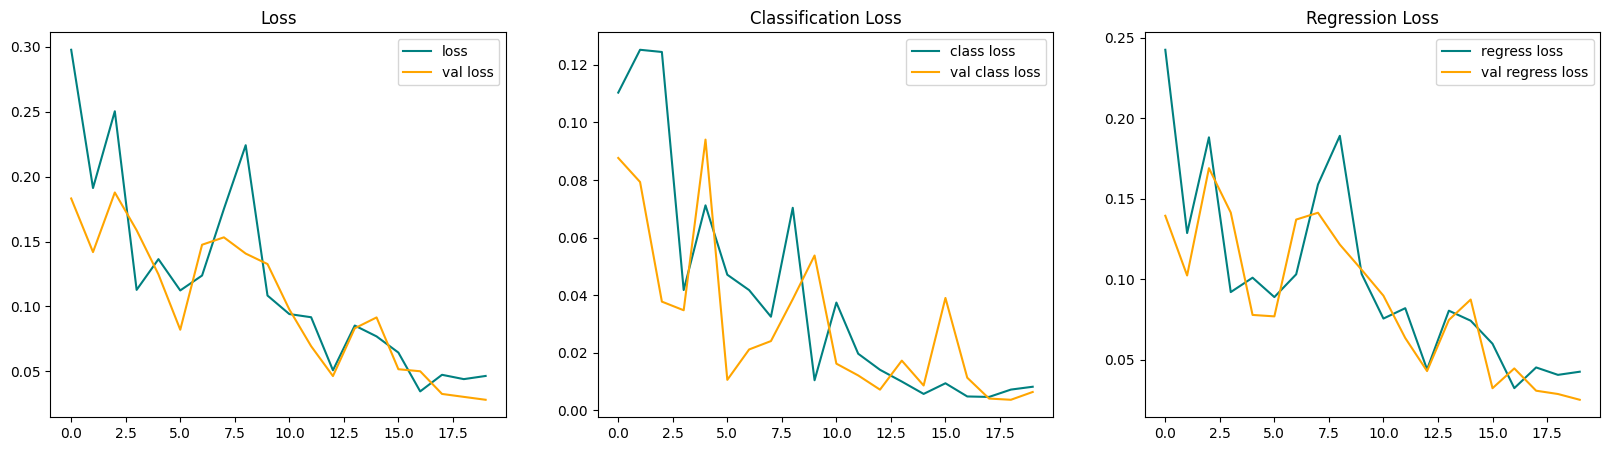

In [32]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Test data

In [57]:
test_sample = test.as_numpy_iterator().next()
yhat = signdetector.predict(test_sample[0])

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 31ms/step


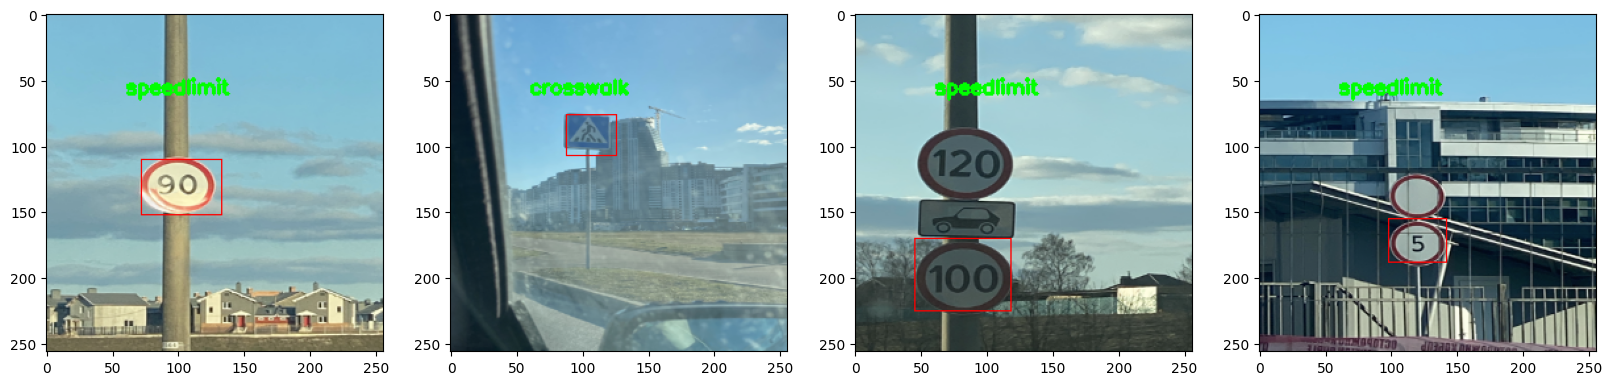

In [82]:
test_sample = test.as_numpy_iterator().next()
yhat = signdetector.predict(test_sample[0])

sign_names=["trafficlight","stop",'speedlimit',"crosswalk"]

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.5
color = (0, 255, 0)
thickness = 2

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
  sample_image = test_sample[0][idx]
  sample_coords = yhat[1][idx]

  label = np.argmax(yhat[0][idx])
  name = sign_names[label]

  sample_image=cv2.rectangle(sample_image,
                tuple(np.multiply(sample_coords[:2], [256,256]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [256,256]).astype(int)),
                (255,0,0), 1)
  sample_image=cv2.putText(sample_image,name,(60,60),font, 
                   fontScale, color, thickness)
  ax[idx].imshow(sample_image)


# Model saving

In [69]:
signdetector.save("/content/drive/MyDrive/DataScience/Traffic_sign/signdetector.h5")

In [ ]:
model2=load_model("signdetector.h5")